In [16]:
from dolfin import *
import mshr
import matplotlib.pyplot as plt
from __future__ import print_function


# Constants related to the geometry
xmin = 0.0; xmax = 7.5
ymin = 0.0; ymax = 1.
xcenter = 1.; ycenter = 0.55; radius = 0.2

# Define geometry
g = mshr.Rectangle(Point(xmin, ymin), Point(xmax, ymax)) - mshr.Circle(Point(xcenter, ycenter), radius, 40)
m = mshr.generate_mesh(g, 40)


# refine mesh TWICE around the cylinder
for refinements in [0, 1]:
    cell_markers = CellFunction("bool", m)
    cell_markers.set_all(False)
    for cell in cells(m):
        p = cell.midpoint()
        if ((xcenter/2. < p[0] < (xmax - xcenter)/2.) and \
            (ycenter/4. < p[1] < ymax - ycenter/4.)):
            cell_markers[cell] = True
    m = refine(m, cell_markers)

File("circle_obstacle.xml.gz") << m

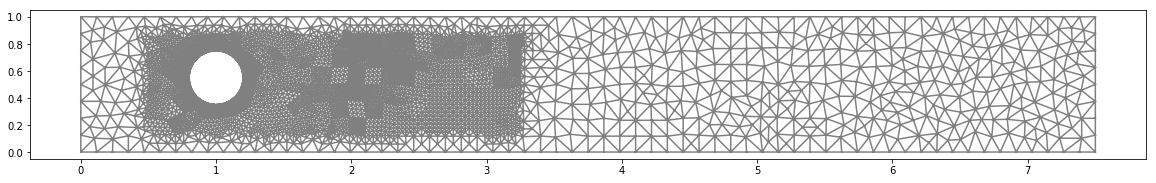

In [17]:
plt.figure(figsize=(20, 8))
plot(m)
plt.show()

In [18]:
# Print log messages only from the root process in parallel
parameters["std_out_all_processes"] = False;

# Load mesh from file
mesh = Mesh("circle_obstacle.xml.gz")

# Define function spaces (P2-P1)
V = VectorFunctionSpace(mesh, "CG", 2)
Q = FunctionSpace(mesh, "CG", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

# Set parameter values
dt = 0.00075
T = 9.
nu = 0.001

# Define boundary conditions
g1 = Expression(("4.* Um * (x[1] * (ymax-x[1]))/(ymax * ymax)" , "0.0"), Um=1.5, ymax=1., element=V.ufl_element())

noslip  = DirichletBC(V, (0, 0),
                      "(x[1] < DOLFIN_EPS | x[1] > 1. - DOLFIN_EPS | \
                       ((x[0] - 1) * (x[0] - 1) + (x[1] - 0.55) * (x[1] - 0.55) < 0.04001 + DOLFIN_EPS))")
outflow = DirichletBC(Q, 0, "x[0] > 7.4999 - DOLFIN_EPS")
in_v = DirichletBC(V, g1, "x[0] < DOLFIN_EPS")
out_v = DirichletBC(V, g1, "x[0] > 7.4999 - DOLFIN_EPS")

bcu = [noslip, in_v, out_v]
bcu_min = [noslip]
bcp = [outflow]

# Create functions
u0 = Function(V)
u1 = Function(V)
curlvtk = Function(V)
p1 = Function(Q)

# Define coefficients
k = Constant(dt)
f = Constant((0, 0))

# Tentative velocity step
F1 = (1/k)*inner(u - u0, v)*dx + inner(grad(u0)*u0, v)*dx + \
     nu*inner(grad(u), grad(v))*dx - inner(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Pressure update
a2 = inner(grad(p), grad(q))*dx
L2 = -(1/k)*div(u1)*q*dx

# Velocity update
a3 = inner(u, v)*dx
L3 = inner(u1, v)*dx - k*inner(grad(p1), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Use amg preconditioner if available
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Create files for storing solution
ufile = File("results/karman/velocity.pvd")
pfile = File("results/karman/pressure.pvd")

# Time-stepping
t = dt
step = 0
while t < T + DOLFIN_EPS:

    # Compute tentative velocity step
    begin("Computing tentative velocity")
    b1 = assemble(L1)
    [bc.apply(A1, b1) for bc in bcu]
    solve(A1, u1.vector(), b1, "gmres", "default")
    end()

    # Pressure correction
    begin("Computing pressure correction")
    b2 = assemble(L2)
    [bc.apply(A2, b2) for bc in bcp]
    solve(A2, p1.vector(), b2, "cg", prec)
    end()

    # Velocity correction
    begin("Computing velocity correction")
    b3 = assemble(L3)
    [bc.apply(A3, b3) for bc in bcu]
    solve(A3, u1.vector(), b3, "gmres", "default")
    end()

    if (step % 25 == 0):
        # Save to file
        ufile << u1
        pfile << p1
        print("t =", t)

    # Move to next time step
    u0.assign(u1)
    t += dt
    step += 1
    

t = 0.00075
t = 0.019500000000000007
t = 0.03825000000000002
t = 0.05700000000000004
t = 0.07575000000000005
t = 0.09450000000000007
t = 0.11325000000000009
t = 0.1320000000000001
t = 0.1507500000000001
t = 0.16950000000000012
t = 0.18825000000000014
t = 0.20700000000000016
t = 0.22575000000000017
t = 0.2445000000000002
t = 0.2632499999999997
t = 0.28199999999999903
t = 0.30074999999999835
t = 0.3194999999999977
t = 0.338249999999997
t = 0.3569999999999963
t = 0.37574999999999564
t = 0.39449999999999497
t = 0.4132499999999943
t = 0.4319999999999936
t = 0.45074999999999293
t = 0.46949999999999226
t = 0.4882499999999916
t = 0.5069999999999915
t = 0.5257499999999922
t = 0.5444999999999929
t = 0.5632499999999936
t = 0.5819999999999943
t = 0.600749999999995
t = 0.6194999999999957
t = 0.6382499999999964
t = 0.6569999999999971
t = 0.6757499999999979
t = 0.6944999999999986
t = 0.7132499999999993
t = 0.732
t = 0.7507500000000007
t = 0.7695000000000014
t = 0.7882500000000021
t = 0.80700000000000